# Temporal-Difference (TD) Learning

In [28]:
%matplotlib inline
import sys
import gym
import matplotlib
import numpy as np
import itertools
from environments.windy_gridworld import WindyGridWorldEnv
from utils import EpisodeStats, plot_episode_stats
from collections import defaultdict
from jupyterthemes import jtplot
jtplot.style(theme='monokai', ticks=True)

In [4]:
env = WindyGridWorldEnv()

## TD Prediction

* learns directly from episodes of experience
* no knowledge of MDP transitions/rewards
* learns from incomplete episodes, by **bootstrapping**
* updates a guess towards a guess

### TD(0)

Update value $V(S_t)$ toward estimated return $R_{t+1}+\gamma V(S_{t+1})$
$$ V(S_t)\leftarrow V(S_t)+\alpha(R_{t+1}+\gamma V(S_{t+1})-V(S_t))$$

* $R_{t+1}+\gamma V(S_{t+1})$ is called the **TD target**
* $\delta_t=R_{t+1}+\gamma V(S_{t+1})-V(S_t)$ is called the **TD error**

### TD($\lambda$)

#### n-Step

n-step return:
$$G_t^{(n)} = R_{t+1}+\gamma R_{t+2}+...+\gamma^{n-1}R_{t+n}+\gamma^n V(S_{t+n})$$

n-step temporal difference learning:
$$ V(S_t)\leftarrow V(S_t)+\alpha(G_t^{(n)}-V(S_t))$$

#### Forward View of TD($\lambda$)

The $\lambda$-return $G_t^\lambda$ combines all n-step returns $G_t^{(n)}$ using weight $(1-\lambda)\lambda^{n-1}$

$$ G_t^\lambda=(1-\lambda)\sum_{n=1}^{\infty}\lambda^{n-1}G_t^{(n)}$$

Forward-view TD($\lambda$)
$$ V(S_t)\leftarrow V(S_t)+\alpha(G_t^\lambda-V(S_t))$$

#### Backward View of TD($\lambda$)

** Eligibility Traces **
* Frequency heuristic: assign credit to most frequent states
* Recency heurestic: assign credit to most recent states

Eligibility traces combine both heuristics
* $ E_0(s)=0 $
* $ E_t(s)=\gamma\lambda E_{t-1}(s)+\mathbb{1}(S_t=s)$
* Keep an eligibility trace for every state $s$
* Update the value $V(s)$ for every state $s$ in proportion to TD-error $\delta_t$ and eligibility trace $E_t(s)$

$$ \delta_t = R_{t+1}+\gamma V(S_{t+1})-V(S_t) $$
$$ V(s)\leftarrow V(s)+\alpha\delta_t E_t(s)$$ 

## On-Policy TD Control

### Sarsa

#### Updating Action-Value Functions with Sarsa

$$Q(S,A)\leftarrow (Q,A)+\alpha(R+\gamma Q(S',A')-Q(S,A))$$

#### Algorithm for On-Policy Control (Pseudo)

Initialize $Q(s,a)$, $\forall s \in S$, $a \in A(s)$, arbitrarily, and $Q(terminal-state,\cdot)=0$

**Repeat**(for each episode):
* Initialize $S$
* Choose $A$ from $S$ using policy derived from $Q$(e.g., $\epsilon$-greedy)
* **Repeat** (for each step of episode):
    * Take action $A$, observe $R$, $S'$
    * Choose $A'$ from $S'$ using policy derived from $Q$(e.g., $\epsilon$-greedy)
    * $Q(S,A)\leftarrow Q(S,A)+\alpha[R+\gamma Q(S',A')-Q(S,A)]$
    * $S\leftarrow S'; A\leftarrow A';$
* **until** $S$ in terminal

#### Code

In [19]:
def epsilon_greedy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float)*epsilon/nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0-epsilon)
        return A
    return policy_fn

In [34]:
def sarsa(env, n_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # for displaying stats
    stats = EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))
    
    policy = epsilon_greedy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(n_episodes):
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, n_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        for t in itertools.count():
            next_state, reward, done, _ = env.step(action)
            
            next_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
            
            # update stats
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            target = reward+discount_factor*Q[next_state][next_action]
            Q[state][action] += alpha*(target-Q[state][action])
            if done:
                break
            state, action = next_state, next_action
            
    
    return Q, stats

In [35]:
Q, stats = sarsa(env, 200)

Episode 200/200.

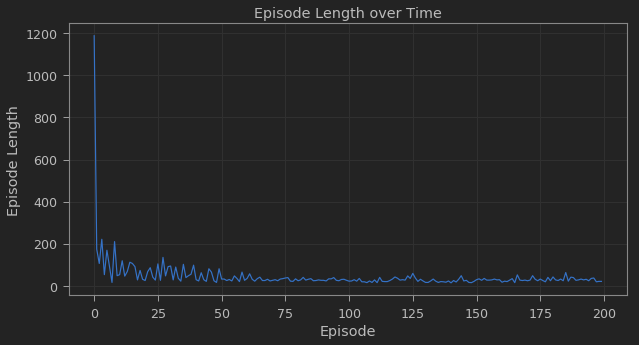

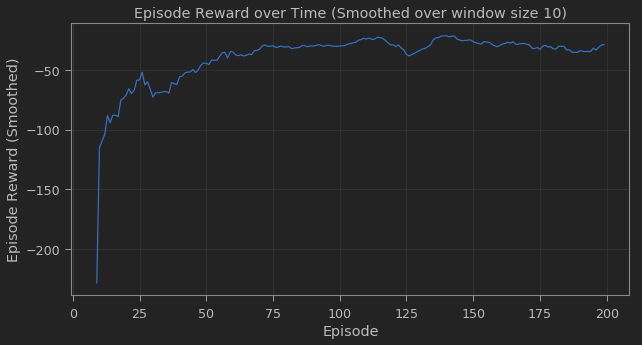

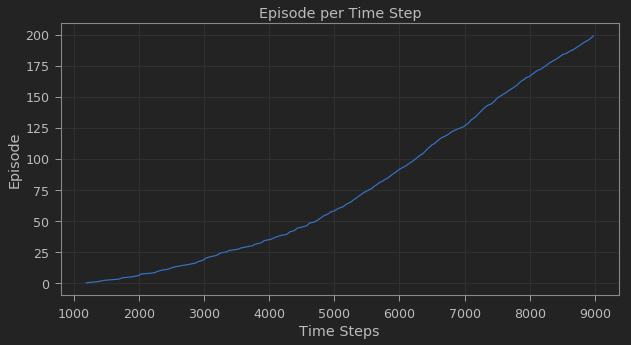

(<matplotlib.figure.Figure at 0x7fd44e6bc048>,
 <matplotlib.figure.Figure at 0x7fd44e5deba8>)

In [36]:
plot_episode_stats(stats)

### Sarsa($\lambda$)

##### n-Step Sarsa

n-step Q-return

$q_t^{(n)}=R_{t+1}+\gamma R_{t+2}+...+\gamma^{n-1}R_{t+n}+\gamma^n Q(S_{t+n})$

n-step Sarsa updates $Q(s,a)$ towards the n-step in Q-return
$$Q(S_t,A_t)\leftarrow Q(S_t,A_t)+\alpha(q_t^{(n)}-Q(S_t,A_t))$$

#### Forward View Sarsa($\lambda$)

The $q^\lambda$ return compines all n-step Q-returns $q_t^{(n)}$, using weight $(1-\lambda)\lambda^{n-1}$

$q_t^\lambda = (1-\lambda)\sum_{n=1}^{\infty}\lambda^{n-1}q_t^{(n)}$

Forward view Sarsa($\lambda$)
$$Q(S_t,A_t)\leftarrow Q(S_t,A_t)+\alpha(q_t^\lambda-Q(S_t,A_t))$$

#### Backward View Sarsa($\lambda$)

Sarsa($\lambda$) hasone eligibility trace for eact state-action pair

$E_0(s,a)=0$

$E_t(s,a)=\gamma\lambda E_{t-1}(s,a)+\mathbb{1}(S_t=s,A_t=a)$

$Q(s,a)$ is updated for every state $s$ and action $a$ in proportion to TD-error $\delta_t$ and eligibility trace $E_t(s,a)$

$\delta_t=R_{t+1}+\gamma Q(S_{t+1},A_{t+1})-Q(S_t,A_t)$
$$Q(s,a)\leftarrow Q(s,a)+\alpha\delta_t E_t(s,a)$$

## Off-Policy TD Control

### Q-Learning

* No importance sampling required
* Next action is chosen using **behaviour policy** $A_{t+1}\sim\mu(\cdot|S_t)$
* But we consider alternative successor action using **target policy** $A'\sim\pi(\cdot|S_t)$
* And update $Q(S_t|A_t)$ towards value of alternative action

$$Q(S_t,A_t)\leftarrow Q(S_t,A_t)+\alpha(R_{t+1}+\gamma Q(S_{t+1},A')-Q(S_t,A_t))$$


We now allow both behaviour and target policies to improve
* Target policy $\pi$ is greedy w.r.t. $Q(s,a)$

$$\pi(S_{t+1})=argmax_{a'}Q(S_{t+1},a')$$

* Behaviour policy $\mu$ is e.g. $\epsilon$-greedy w.r.t. $Q(s,a)$
* The Q-Learning target then simplifies:

$R_{t+1}+\gamma Q(S_{t+1},A')$

$=R_{t+1}+\gamma Q(S_{t+1}, argmax_{a'}Q(S_{t+1},a'))$

$=R_{t+1}+max_{a'}\gamma Q(S_{t+1}, a')$

$$Q(S,A)\leftarrow Q(S,A)+\alpha(R+\gamma max_{a'}Q(S',a')-Q(S,A))$$

#### Q-Learning Algorithm for Off-Policy Control (Pseudo)

Initialize $Q(s,a)$, $\forall s \in S$, $a \in A(s)$, arbitrarily, and $Q(terminal-state,\cdot)=0$
**Repeat** (for each episode):
* Initialize $S$
* **Repeat** (for each step of episode):
    * Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
    * Take action $A$, observe $R$, $S'$
    * $Q(S,A)\leftarrow Q(S,A)+\alpha[R+\gamma max_aQ(S',a)-Q(S,A)]$
    * $S\leftarrow S'$;
* **until** $S$ is terminal

In [41]:
from gym.envs.toy_text import CliffWalkingEnv

In [42]:
env = CliffWalkingEnv()

In [47]:
def q_learning(env, n_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    stats = EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))
    
    policy = epsilon_greedy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(n_episodes):
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, n_episodes), end="")
            sys.stdout.flush()
        state = env.reset()
        for t in itertools.count():
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            
            # update stats
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            best_action = np.argmax(Q[next_state])
            target = reward+discount_factor*Q[next_state][best_action]
            Q[state][action] += alpha*(target-Q[state][action])
            if done:
                break
            state = next_state
    return Q, stats

In [48]:
Q, stats = q_learning(env, 200)

Episode 200/200.

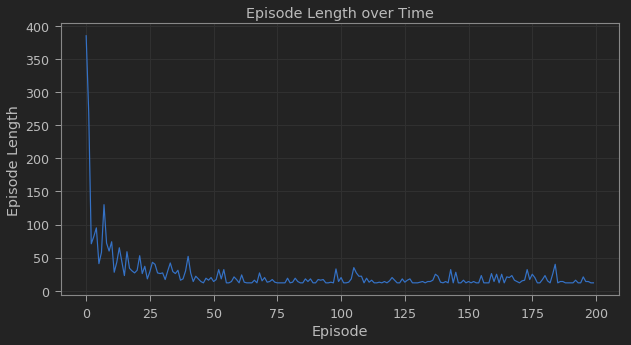

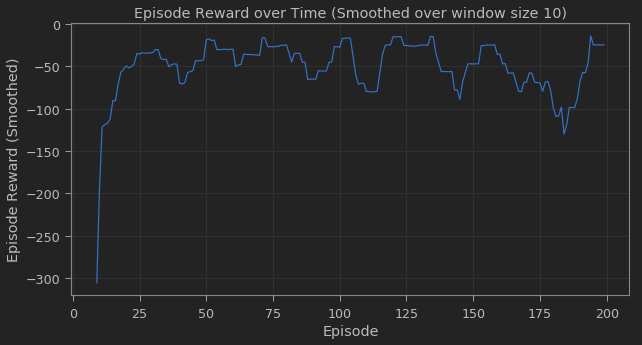

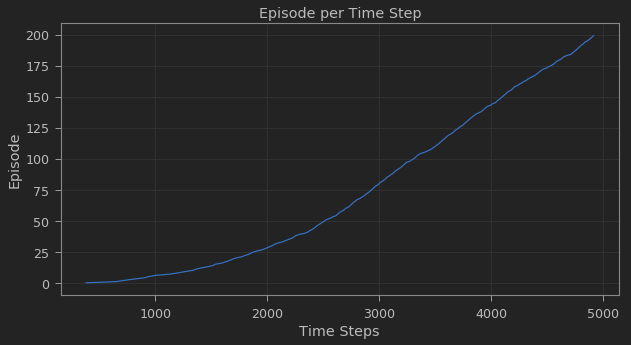

(<matplotlib.figure.Figure at 0x7fd44e4dfba8>,
 <matplotlib.figure.Figure at 0x7fd44e3fe400>)

In [49]:
plot_episode_stats(stats)